In [74]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet121, DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report
import numpy as np
# disable the warnings
import logging
logger = logging.getLogger('matplotlib')
logger.setLevel(100)
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image  # Import the Image module
import os

In [13]:
with open('/kaggle/input/no-rotation/no_rot_preprocessed_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
x = loaded_data['data']
y = loaded_data['labels']

# augment the data(rotation only)

In [36]:
augmented_pkl_file_path= '/kaggle/working/augmented_dataset.pkl'
augmented_pkl_file_path = os.path.join(augmented_pkl_file_path, "augmented_dataset.pkl")




# Step 2: Define augmentation transformations
transform = A.Compose([
    A.Rotate(limit=15, p=0.7)

    # Add more augmentations as needed
   
])

# Step 3: Augment the data
augmented_dataset = []
for image_data in x:
    # Convert to NumPy array if it's a PIL Image
    if isinstance(image_data, Image.Image):
        image_data = np.array(image_data)
    
    # Ensure the image is a NumPy array
    if isinstance(image_data, np.ndarray):
        augmented = transform(image=image_data)
        augmented_entry =augmented['image'] # Update the key accordingly
        augmented_dataset.append(augmented_entry)

# Print some information for debugging
print("Original Dataset Length:", len(x))
print("Augmented Dataset Length:", len(augmented_dataset))

# Step 4: Save the augmented dataset to a new .pkl file

with open(augmented_pkl_file_path, 'wb') as file:
    pickle.dump({'data': augmented_dataset, 'labels': y}, file)

print("Augmented Dataset saved successfully.")

Original Dataset Length: 1040
Augmented Dataset Length: 1040
Augmented Dataset saved successfully.


In [63]:
len(dataset2['labels'])

1040

# concatenate rotated data and not rotated

In [66]:
# Step 1: Load datasets from the .pkl files
pkl_file_path1 = "/kaggle/input/no-rotation/no_rot_preprocessed_data.pkl"
pkl_file_path2 = "/kaggle/working/augmented_dataset.pkl/augmented_dataset.pkl"

with open(pkl_file_path1, 'rb') as file:
    dataset1 = pickle.load(file)

with open(pkl_file_path2, 'rb') as file:
    dataset2 = pickle.load(file)

# Step 2: Merge the datasets
data_x = np.concatenate((dataset1['data'], dataset2['data']))
label_x = np.concatenate((dataset1['labels'], dataset2['labels']))


# Step 3: Save the merged dataset to a new .pkl file
merged_pkl_file_path = "/kaggle/working/augmented_dataset.pkl"

with gzip.open('merged_pkl_file_path', 'wb') as f:
       pickle.dump({'data':data_x,'labels':label_x}, f)

# load new data

In [67]:
with gzip.open('/kaggle/working/merged_pkl_file_path', 'rb') as file:
       merged_dataset1= pickle.load(file)
X=merged_dataset1['data']
Y=merged_dataset1['labels']

# training the model

In [68]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y= to_categorical(Y, num_classes=26)

In [71]:
len(X)

2080

In [72]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.15,
                                                    stratify=Y,
                                                    random_state=42)

In [75]:
checkpoint_cb = ModelCheckpoint('checkpoints', save_best_only=True,
                                save_weights_only=True, verbose=1)
reduce_lr_cb = ReduceLROnPlateau(patience=10,verbose=1)
early_stopping_cb = EarlyStopping(patience=30, 
                                  restore_best_weights=True,
                                  start_from_epoch=20,
                                  verbose=1)

In [76]:
base_model = DenseNet201(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
output = Dense(26, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

74836368/74836368 [==============================] - 0s 0us/step


In [77]:
history = model.fit(x_train, y_train, epochs=1000, 
                    validation_split=0.2, 
                    callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb])

Epoch 1/1000
45/45 [==============================] - ETA: 0s - loss: 3.4721 - accuracy: 0.0799
Epoch 1: val_loss improved from inf to 3.25366, saving model to checkpoints
45/45 [==============================] - 45s 394ms/step - loss: 3.4721 - accuracy: 0.0799 - val_loss: 3.2537 - val_accuracy: 0.1186 - lr: 0.0010
Epoch 2/1000
44/45 [============================>.] - ETA: 0s - loss: 2.8576 - accuracy: 0.2095
Epoch 2: val_loss improved from 3.25366 to 3.00745, saving model to checkpoints
45/45 [==============================] - 9s 206ms/step - loss: 2.8568 - accuracy: 0.2100 - val_loss: 3.0075 - val_accuracy: 0.1441 - lr: 0.0010
Epoch 3/1000
44/45 [============================>.] - ETA: 0s - loss: 2.2581 - accuracy: 0.3643
Epoch 3: val_loss improved from 3.00745 to 2.83818, saving model to checkpoints
45/45 [==============================] - 9s 207ms/step - loss: 2.2569 - accuracy: 0.3635 - val_loss: 2.8382 - val_accuracy: 0.1836 - lr: 0.0010
Epoch 4/1000
44/45 [=======================

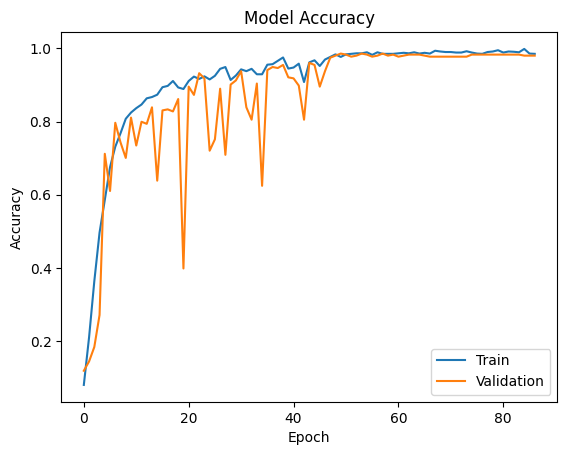

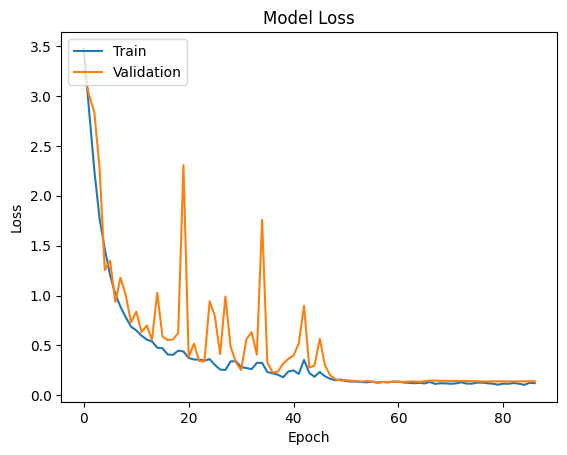

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [80]:
model.evaluate(x_train, y_train)

56/56 [==============================] - 10s 184ms/step - loss: 0.0863 - accuracy: 0.9960


[0.08631069213151932, 0.9960407018661499]

56/56 [==============================] - 11s 135ms/step


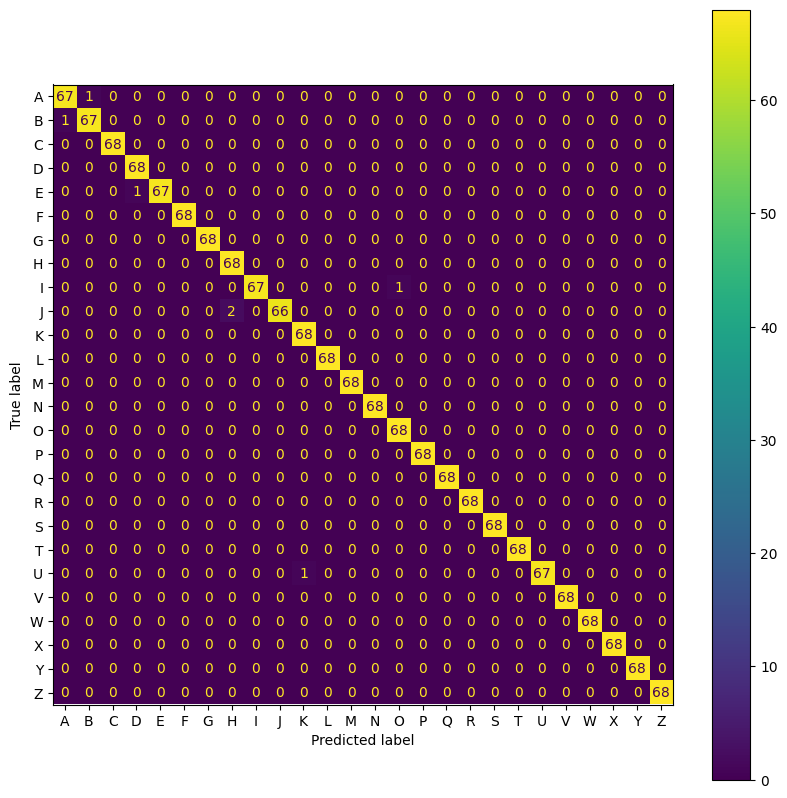

In [81]:
y_pred_probs_train = model.predict(x_train)
y_pred_train = np.argmax(y_pred_probs_train, axis=1)
y_true_train = np.argmax(y_train, axis=1)  # Assuming y_train is one-hot encoded
cm = confusion_matrix(y_true_train, y_pred_train)

fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax)
plt.show()

In [82]:
precision = precision_score(y_true_train, y_pred_train, average='macro')
print('Training precision: %.3f' % precision)

Training precision: 0.996


In [83]:
recall = recall_score(y_true_train, y_pred_train, average='macro')
print('Training recall: %.3f' % recall)

Training recall: 0.996


In [84]:
report = classification_report(y_true_train, y_pred_train, target_names=class_names)

print(report)

              precision    recall  f1-score   support

           A       0.99      0.99      0.99        68
           B       0.99      0.99      0.99        68
           C       1.00      1.00      1.00        68
           D       0.99      1.00      0.99        68
           E       1.00      0.99      0.99        68
           F       1.00      1.00      1.00        68
           G       1.00      1.00      1.00        68
           H       0.97      1.00      0.99        68
           I       1.00      0.99      0.99        68
           J       1.00      0.97      0.99        68
           K       0.99      1.00      0.99        68
           L       1.00      1.00      1.00        68
           M       1.00      1.00      1.00        68
           N       1.00      1.00      1.00        68
           O       0.99      1.00      0.99        68
           P       1.00      1.00      1.00        68
           Q       1.00      1.00      1.00        68
           R       1.00    

In [85]:
model.evaluate(x_test, y_test)

10/10 [==============================] - 5s 478ms/step - loss: 0.1260 - accuracy: 0.9808


[0.12602859735488892, 0.9807692170143127]

10/10 [==============================] - 1s 141ms/step


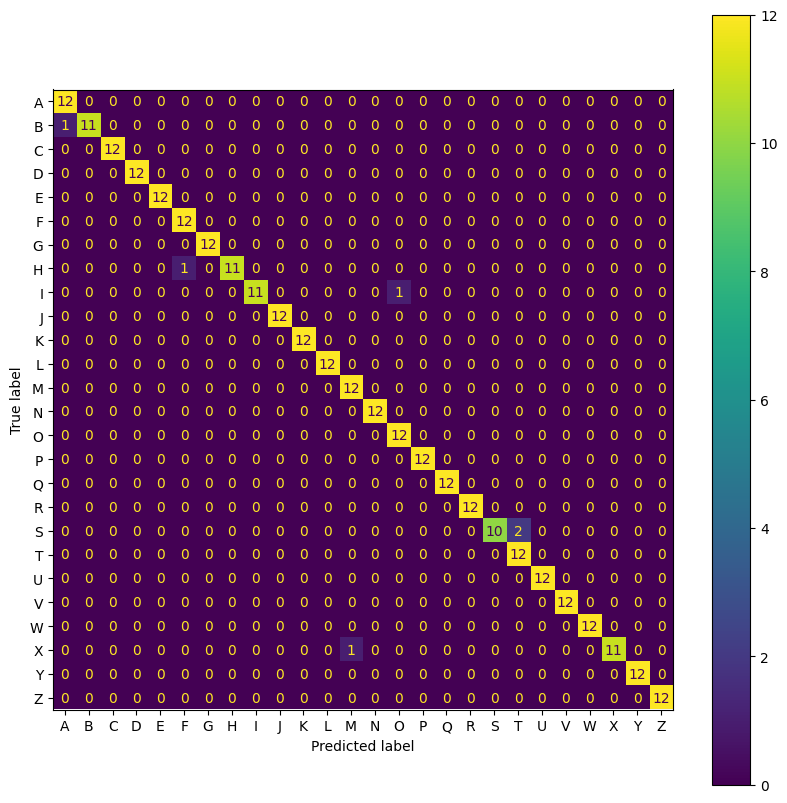

In [86]:
y_pred_probs_test = model.predict(x_test)
y_pred_test = np.argmax(y_pred_probs_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)  # y_test is one-hot encoded

cm = confusion_matrix(y_true_test, y_pred_test)

fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax) 
plt.show()

In [87]:
precision = precision_score(y_true_test, y_pred_test, average='macro')
print('Test precision: %.3f' % precision)

Test precision: 0.983


In [88]:
recall = recall_score(y_true_test, y_pred_test, average='macro')
print('Test precision: %.3f' % recall)

Test precision: 0.981


In [89]:
report = classification_report(y_true_test, y_pred_test, target_names=class_names)

print(report)

              precision    recall  f1-score   support

           A       0.92      1.00      0.96        12
           B       1.00      0.92      0.96        12
           C       1.00      1.00      1.00        12
           D       1.00      1.00      1.00        12
           E       1.00      1.00      1.00        12
           F       0.92      1.00      0.96        12
           G       1.00      1.00      1.00        12
           H       1.00      0.92      0.96        12
           I       1.00      0.92      0.96        12
           J       1.00      1.00      1.00        12
           K       1.00      1.00      1.00        12
           L       1.00      1.00      1.00        12
           M       0.92      1.00      0.96        12
           N       1.00      1.00      1.00        12
           O       0.92      1.00      0.96        12
           P       1.00      1.00      1.00        12
           Q       1.00      1.00      1.00        12
           R       1.00    

# save the model

In [90]:
model.save('rotation_new_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
